## MNIST Handwritten Digit Recognition

Using simple linear model for predicting handwritten Digit Recognition

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import gzip
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix

## Load Data

    load MNIST Data to list

In [5]:

# filename for the dataset
filename_x_train = "train-images-idx3-ubyte.gz"
filename_y_train = "train-labels-idx1-ubyte.gz"
filename_x_test = "t10k-images-idx3-ubyte.gz"
filename_y_test = "t10k-labels-idx1-ubyte.gz"

# MNIST images are 28 pixels in each dimension.
img_size = 28

# Store the images in one-dimensional list of length:
img_size_flat = img_size * img_size

# The height and width of the image.
img_shape = (img_size, img_size)

# number of colour channels. 
num_channels = 1

# Tuple with height, width and depth
img_shape_full = (img_size, img_size, num_channels)

# Number of digit that will be recognized
num_classes = 10

In [6]:
# Data folder
data_dir = "MNIST/"

In [46]:
# Number of images in each subset
num_train = 55000
num_val = 5000
num_test = 10000

def _load_data(filename, offset):
        """
        Load the data in the given file. Automatically downloads the file
        if it does not already exist in the data_dir.

        :param filename: Name of the data-file.
        :param offset: Start offset in bytes when reading the data-file.
        :return: The data as a numpy array.
        """

        # Read the data-file.
        path = os.path.join(data_dir, filename)
        with gzip.open(path, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=offset)

        return data

# Load the data
def _load_images(filename):
        """
        Load image-data from the given file.
        Automatically downloads the file if it does not exist locally.

        :param filename: Name of the data-file.
        :return: Numpy array.
        """

        # Read the data as one long array of bytes.
        data = _load_data(filename=filename, offset=16)

        # Reshape to 2-dim array with shape (num_images, img_size_flat).
        images_flat = data.reshape(-1, img_size_flat)

        return images_flat
def _load_cls( filename):
        """
        Load class-numbers from the given file.
        Automatically downloads the file if it does not exist locally.

        :param filename: Name of the data-file.
        :return: Numpy array.
        """
        return _load_data(filename=filename, offset=8)
def random_batch(batch_size=32):
        """
        Create a random batch of training-data.

        :param batch_size: Number of images in the batch.
        :return: 3 numpy arrays (x, y, y_cls)
        """

        # Create a random index into the training-set.
        idx = np.random.randint(low=0, high=num_train, size=batch_size)

        # Use the index to lookup random training-data.
        x_batch = x_train[idx]
        y_batch = y_train[idx]
        y_batch_cls = y_train_cls[idx]

        return x_batch, y_batch, y_batch_cls
# load training and validation data
x_train = _load_images(filename = filename_x_train)
y_train_cls = _load_cls(filename = filename_y_train)
# split the training set into train and validation
# convert pixel values into from ints b/n 0 and 255 to 0.0 and 1.0
x_train = x_train[0:num_train] / 255.0
x_val = x_train[num_train:] / 255.0
y_train_cls = y_train_cls[0:num_train]
y_val_cls = y_train_cls[num_train:]

# load test data
x_test = _load_images(filename=filename_x_test) / 255.0
y_test_cls = _load_cls(filename = filename_y_test)

# convert the class numbers from bytes to ints as that is needed for Tensorflow
y_train_cls = y_train_cls.astype(np.int)
y_val_cls = y_val_cls.astype(np.int)
y_test_cls = y_test_cls.astype(np.int)

# function for one hot encoding
def one_hot_encoded(class_numbers, num_classes=None):
    """
    Generate the One-Hot encoded class-labels from an array of integers.

    For example, if class_number=2 and num_classes=4 then
    the one-hot encoded label is the float array: [0. 0. 1. 0.]

    :param class_numbers:
        Array of integers with class-numbers.
        Assume the integers are from zero to num_classes-1 inclusive.

    :param num_classes:
        Number of classes. If None then use max(class_numbers)+1.

    :return:
        2-dim array of shape: [len(class_numbers), num_classes]
    """

    # Find the number of classes if None is provided.
    # Assumes the lowest class-number is zero.
    if num_classes is None:
        num_classes = np.max(class_numbers) + 1

    return np.eye(num_classes, dtype=float)[class_numbers]

# Convert the integers class-numbers into one-hot encoded list.
y_train = one_hot_encoded(class_numbers = y_train_cls,
                         num_classes = num_classes)
y_val = one_hot_encoded(class_numbers = y_val_cls,
                       num_classes = num_classes)
y_test = one_hot_encoded(class_numbers = y_test_cls,
                        num_classes = num_classes)

In [13]:
print("Size of:")
print("- Training-set:\t\t{}".format(num_train))
print("- Validation-set:\t{}".format(num_val))
print("- Test-set:\t\t{}".format(num_test))

Size of:
- Training-set:		55000
- Validation-set:	5000
- Test-set:		10000


In [20]:
# function for ploting images
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

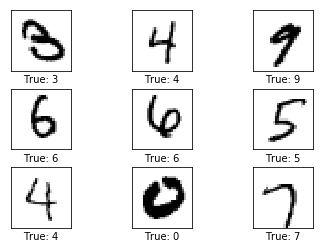

In [27]:
images = x_test[18:27]
cls_true = y_test_cls[18:27]
plot_images(images = images, cls_true=cls_true)

In [28]:
# placeholder variables
x = tf.placeholder(tf.float32, [None, img_size_flat])
y_true = tf.placeholder(tf.float32, [None, num_classes])
y_true_cls = tf.placeholder(tf.int64, [None])

# variables to be optimized 
weights =tf.Variable(tf.zeros([img_size_flat, num_classes]))
biases = tf.Variable(tf.zeros([num_classes]))

# Model
logits = tf.matmul(x, weights) + biases
y_pred = tf.nn.softmax(logits)
y_pred_cls = tf.argmax(y_pred, axis=1)

# cost-function 

cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,
                                                          labels=y_true)
cost = tf.reduce_mean(cross_entropy)

# Optimization method


In [29]:

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost)
# performance measures
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [31]:
# Run the session

session = tf.Session()

# Intialize variables
session.run(tf.global_variables_initializer())

In [44]:
# Function to perform Optimization Iterations.
#            Stochastic Gradient Descent Algorthim
# Batch size for each iteration of the optimizer 
batch_size = 100
def optimize(num_iterations):
    for i in range(num_iterations):
        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch, _ = random_batch(batch_size=batch_size)
        
        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        # Note that the placeholder for y_true_cls is not set
        # because it is not used during training.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

In [34]:
feed_dict_test = {x: x_test,
                  y_true: y_test,
                  y_true_cls: y_test_cls}

def print_accuracy():
    # Use TensorFlow to compute the accuracy.
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    
    # Print the accuracy.
    print("Accuracy on test-set: {0:.1%}".format(acc))



In [35]:
def print_confusion_matrix():
    # Get the true classifications for the test-set.
    cls_true = y_test_cls
    
    # Get the predicted classifications for the test-set.
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Make various adjustments to the plot.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [36]:
def plot_example_errors():
    # Use TensorFlow to get a list of boolean values
    # whether each test-image has been correctly classified,
    # and a list for the predicted class of each image.
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = x_test[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = y_test_cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [37]:
def plot_weights():
    # Get the values for the weights from the TensorFlow variable.
    w = session.run(weights)
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Create figure with 3x4 sub-plots,
    # where the last 2 sub-plots are unused.
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Only use the weights for the first 10 sub-plots.
        if i<10:
            # Get the weights for the i'th digit and reshape it.
            # Note that w.shape == (img_size_flat, 10)
            image = w[:, i].reshape(img_shape)

            # Set the label for the sub-plot.
            ax.set_xlabel("Weights: {0}".format(i))

            # Plot the image.
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        # Remove ticks from each sub-plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

## Run Session

In [38]:
print_accuracy()

Accuracy on test-set: 9.8%


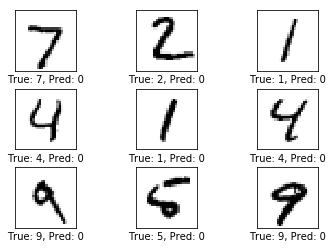

In [39]:
plot_example_errors()

In [71]:
for i in range(0,10):
    optimize(num_iterations=1000)

In [72]:
print_accuracy()

Accuracy on test-set: 92.1%


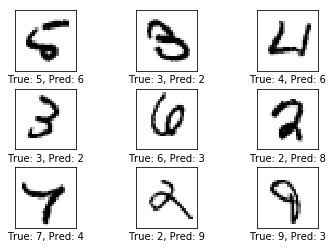

In [73]:
plot_example_errors()

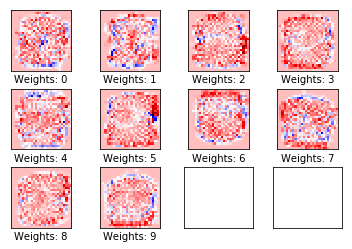

In [74]:
plot_weights()

[[ 957    0    1    2    2    9    5    2    2    0]
 [   0 1109    4    3    0    1    3    2   13    0]
 [  10    9  886   21   12    6   13   10   61    4]
 [   4    2   14  917    3   18    4   11   31    6]
 [   1    4    5    4  928    0    9    4    6   21]
 [  10    3    1   37   11  758   17    9   42    4]
 [  10    3    4    2    8   13  912    2    4    0]
 [   2    7   14    8    7    1    0  952    5   32]
 [   9   10    3   13    7   17    6    7  892   10]
 [   7    5    0    9   38    7    0   30   14  899]]


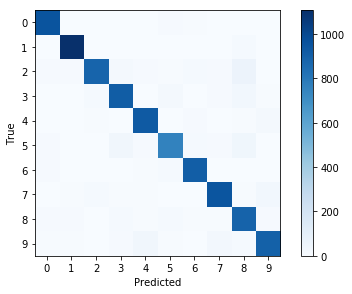

In [75]:
print_confusion_matrix()

In [76]:
session.close()